<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/XTRA_NEURO_NET_EXERCISES/3_rnn_frozen_dessert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(42)

In [41]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

import fileinput
filePath ="/content/gdrive/MyDrive/neural_data/Frozen_Dessert_Production.csv"

import pandas as pd
df = pd.read_csv(filePath,index_col='DATE',parse_dates=True)

df.head(3)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [43]:
df.columns = ['Production']

<Axes: xlabel='DATE'>

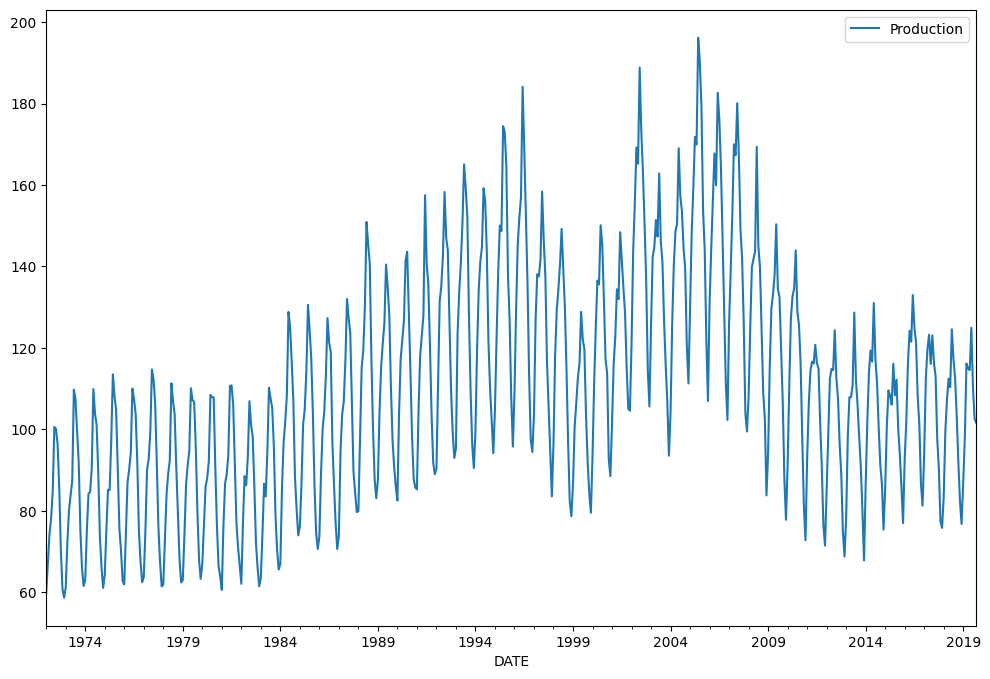

In [44]:
df.plot(figsize=(12,8))

## Train Test Split

In [45]:
# data is monthly, do forest for 1.5 years into the future
len(df)


573

In [46]:
test_size = 24

In [47]:
test_ind = len(df)- test_size

In [48]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [49]:
train.head(3)

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350


In [50]:
test.head(3)

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118


## Scale Data

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [52]:
scaler.fit(train)

MinMaxScaler()

In [53]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [54]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [55]:
length = 18
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [56]:
# What does the first batch look like?
X,y = generator[0]

In [57]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.
 0.01774221 0.09850931 0.15590133 0.18358944 0.20878908 0.37150354]
Predict this y: 
 [[0.3542551]]


## Create the Model

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [59]:
# We're only using one feature in our time series
n_features = 1

In [60]:
model = Sequential()
model.add(LSTM(300, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 300)               362400    
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [63]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [64]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


<ipython-input-64-3878a3328f67>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


531/531 [==============================] - 19s 32ms/step - loss: 0.0233 - val_loss: 0.0038
Epoch 2/20
531/531 [==============================] - 17s 32ms/step - loss: 0.0067 - val_loss: 0.0039
Epoch 3/20
531/531 [==============================] - 16s 30ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 4/20
531/531 [==============================] - 16s 30ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 5/20
531/531 [==============================] - 16s 30ms/step - loss: 0.0036 - val_loss: 0.0035


In [65]:
losses = pd.DataFrame(model.history.history)

<Axes: >

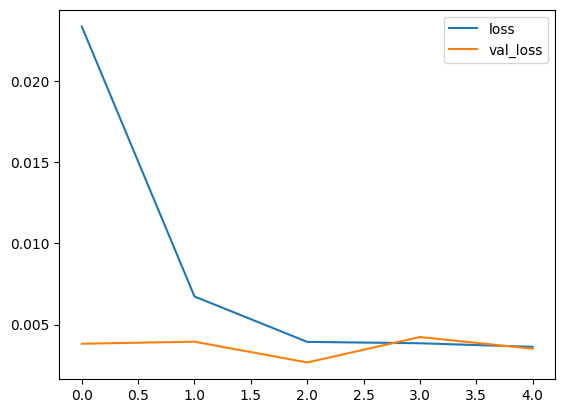

In [66]:
losses.plot()

## Evaluate on Test Data

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):

    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    test_predictions.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 41ms/step


In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
test['Predictions'] = true_predictions

<ipython-input-69-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [70]:
test.head(5)

,Production,Predictions
DATE,,
2017-10-01,90.4732,91.596303
2017-11-01,77.4378,85.798204
2017-12-01,75.8118,87.386309
2018-01-01,83.4343,98.760057
2018-02-01,99.4899,111.122813


<Axes: xlabel='DATE'>

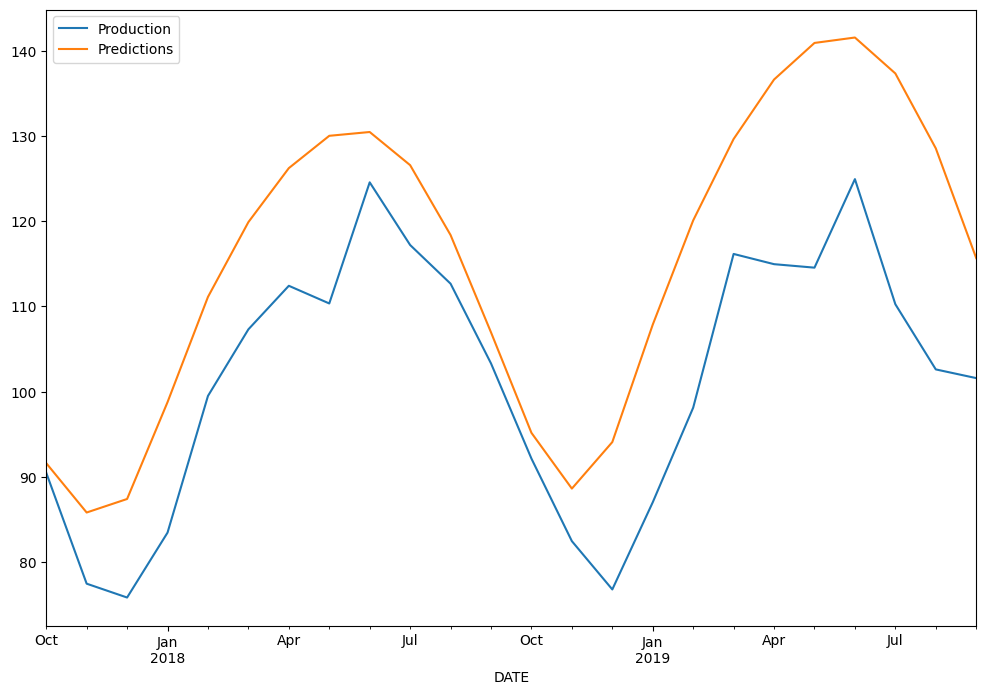

In [71]:
test.plot(figsize=(12,8))

In [72]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

15.788106439874008